In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('default')

c:\Users\debonil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
transform = transforms.ToTensor()

traindataset = datasets.FashionMNIST('.', download=True, train=True, transform=transform)
testdataset = datasets.FashionMNIST('.', download=True, train=False, transform=transform)

In [3]:
bs =1000
trainloader = torch.utils.data.DataLoader(traindataset, batch_size=bs, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=bs, shuffle=False, num_workers=4)

In [4]:
next(iter(testloader))[0].shape
     

torch.Size([1000, 1, 28, 28])

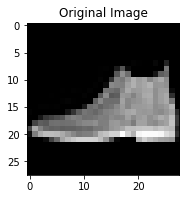

In [5]:

test_images, labels = next(iter(testloader))


  
inp = test_images.view(-1, 28, 28)

fig = plt.figure()
plot = fig.add_subplot(1, 2, 1)
plot.set_title('Original Image')
imgplot = plt.imshow(inp[0].cpu(), cmap='gray')



In [6]:

class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784, 512),
        nn.Sigmoid(),
        nn.Linear(512, 256),
        nn.Sigmoid(),
        nn.Linear(256, 128),
        nn.Sigmoid(),
        nn.Linear(128, 64),
        nn.Sigmoid(),
        )
    self.decoder = nn.Sequential(
        nn.Linear(64, 128),
        nn.Sigmoid(),
        nn.Linear(128, 256),
        nn.Sigmoid(),
        nn.Linear(256, 512),
        nn.Sigmoid(),
        nn.Linear(512, 784),
        nn.Sigmoid()
        )
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x
     

In [7]:

model = AutoEncoder()

In [8]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

In [9]:
optimizer =  torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [10]:
epochs = 20
noise_factor =0.2
for epoch in range(epochs):
  train_loss = 0.0
  
  for images, labels in trainloader:
    ## add random noise to the input images
    noisy_imgs = images + noise_factor * torch.randn(*images.shape)
    # Clip the images to be between 0 and 1
    noisy_imgs = np.clip(noisy_imgs, 0., 1.)
            
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    ## forward pass: compute predicted outputs by passing *noisy* images to the model
    outputs = model(noisy_imgs.view(-1,784))
    # calculate the loss
    # the "target" is still the original, not-noisy images
    loss = criterion(outputs, images.view(-1,784))
    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # perform a single optimization step (parameter update)
    optimizer.step()
    # update running training loss
    train_loss += loss.item()*images.size(0)

  # print avg training statistics 
  train_loss = train_loss/len(trainloader)
  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 0 	Training Loss: 92.309931
Epoch: 1 	Training Loss: 87.116719
Epoch: 2 	Training Loss: 87.092704
Epoch: 3 	Training Loss: 87.104287
Epoch: 4 	Training Loss: 87.119274
Epoch: 5 	Training Loss: 87.097748
Epoch: 6 	Training Loss: 87.124692
Epoch: 7 	Training Loss: 87.110747
Epoch: 8 	Training Loss: 73.798669
Epoch: 9 	Training Loss: 61.970158
Epoch: 10 	Training Loss: 59.768198
Epoch: 11 	Training Loss: 56.376339
Epoch: 12 	Training Loss: 51.898415
Epoch: 13 	Training Loss: 48.544041
Epoch: 14 	Training Loss: 44.487090
Epoch: 15 	Training Loss: 40.269092
Epoch: 16 	Training Loss: 38.276607
Epoch: 17 	Training Loss: 37.287115
Epoch: 18 	Training Loss: 36.043502
Epoch: 19 	Training Loss: 35.325510


In [15]:
test_images, labels = next(iter(testloader))

noisy_test_imgs = np.clip(test_images + noise_factor * torch.randn(*test_images.shape), 0., 1.)

test_output = model(noisy_test_imgs.view(-1,784))


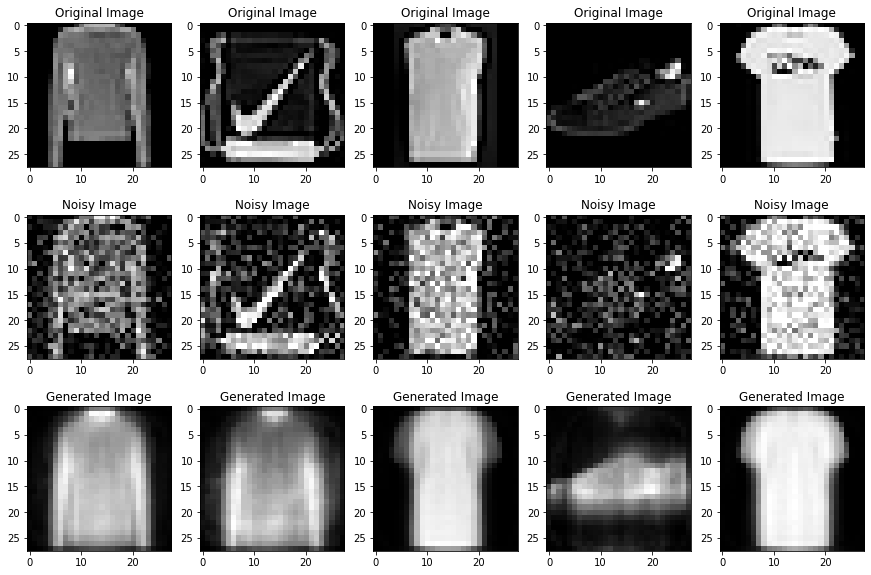

In [25]:

fig = plt.figure(figsize =(15,10))
nrows = 5
b=np.random.randint(0,test_images.shape[0]-nrows)
for i in range(nrows):
    plot = fig.add_subplot( 3,nrows, 0*nrows+i+1)
    plot.set_title('Original Image')
    imgplot = plt.imshow(test_images.view(-1, 28, 28)[b+i].cpu().detach(), cmap='gray')

    plot = fig.add_subplot( 3,nrows,  1*nrows+i+1)
    plot.set_title('Noisy Image')
    imgplot = plt.imshow(noisy_test_imgs.view(-1, 28, 28)[b+i].cpu().detach(), cmap='gray')

    plot = fig.add_subplot( 3,nrows,  2*nrows+i+1)
    plot.set_title('Generated Image')
    imgplot = plt.imshow(test_output.view(-1, 28, 28)[b+i].cpu().detach(), cmap='gray')

plt.show()